<DIV ALIGN=CENTER>

# Introduction to NLP: Topic Modeling
## Professor Robert J. Brunner
  
</DIV>  
-----
-----


## Introduction

Topic modelling:

NLTK
gensim

build on material from L1.

-----

Useful information at https://github.com/nealcaren/quant-text-fall-2014/blob/master/Topic_Modeling_Options.ipynb, http://radimrehurek.com/gensim/tutorial.html, 

What about viz?

https://github.com/bmabey/pyLDAvis

http://cpsievert.github.io/LDAvis/newsgroup/vis/#topic=0&lambda=1&term=


In [1]:
# Set up Notebook

% matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load Dataset
from sklearn.datasets import fetch_20newsgroups

train = fetch_20newsgroups(data_home='/home/data_scientist/data/textdm', 
                           subset='train', shuffle=True, random_state=23,
                           remove=('headers', 'footers', 'quotes'))

test = fetch_20newsgroups(data_home='/home/data_scientist/data/textdm', 
                          subset='test', shuffle=True, random_state=23,
                          remove=('headers', 'footers', 'quotes'))

In [3]:
# Use TD-IDF on newgroup data.
from sklearn.feature_extraction.text import TfidfVectorizer

cv = TfidfVectorizer(stop_words = 'english',
                     lowercase=True,
                     min_df=2,
                     max_features=5000)
                     
train_data = cv.fit_transform(train['data'])
test_data = cv.transform(test['data'])

In [4]:
# Compute topics by using NMF
from sklearn.decomposition import NMF

num_topics = 10
nmf = NMF(n_components = num_topics, max_iter = 1000).fit(train_data)

In [5]:
from helper_code import tpterms as tp

nmf_topics = tp.get_topics(cv, nmf)

Topic  0: people israel government jews israeli armenian state gun law rights
Topic  1: geb dsl chastity n3jxp cadre pitt shameful intellect skepticism surrender
Topic  2: windows file dos files window program use using problem version
Topic  3: game team games year players season play hockey win league
Topic  4: thanks does know mail advance info hi anybody looking help
Topic  5: drive scsi drives disk card hard controller ide floppy bus
Topic  6: key chip encryption clipper keys use escrow government algorithm nsa
Topic  7: just don like think know ve good time really want
Topic  8: 00 edu new sale com space price offer 10 email
Topic  9: god jesus bible believe faith christ christian christians say church


-----

### Understanding Topic Terms

We can build a dataaframe to visualize the relationship between topic terms and the classes.

-----

In [6]:
# We transform and normalize the data, 
# by using l1 so document topic probabilty sums to unity.

from sklearn.preprocessing import normalize

td = nmf.transform(train_data)
td_norm = normalize(td, norm='l1', axis=1)

In [7]:
# We use a DataFrame to simplify the collecting of the data for display.

df = pd.DataFrame(td_norm, columns=nmf_topics)
df.fillna(value=0, inplace=True)
df['label'] = pd.Series(train['target_names'], dtype="category")

df.groupby('label').mean()

,"people, israel, government, jews, israeli","geb, dsl, chastity, n3jxp, cadre","windows, file, dos, files, window","game, team, games, year, players","thanks, does, know, mail, advance","drive, scsi, drives, disk, card","key, chip, encryption, clipper, keys","just, don, like, think, know","00, edu, new, sale, com","god, jesus, bible, believe, faith"
label,,,,,,,,,,
alt.atheism,0.285342,0.000000,0.020032,0.066483,0.025038,0.000000,0.000000,0.314826,0.001408,0.286871
comp.graphics,0.000000,0.471853,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.472011,0.056136
comp.os.ms-windows.misc,0.041019,0.000000,0.000000,0.148504,0.325204,0.000000,0.000000,0.485272,0.000000,0.000000
comp.sys.ibm.pc.hardware,0.106246,0.011236,0.000000,0.008316,0.000000,0.000000,0.000000,0.418056,0.000000,0.456146
comp.sys.mac.hardware,0.000000,0.000000,0.406015,0.000000,0.421238,0.000000,0.000000,0.025196,0.145632,0.001919
comp.windows.x,0.116835,0.000000,0.000000,0.000000,0.383451,0.000000,0.000000,0.400228,0.099487,0.000000
misc.forsale,0.036999,0.000000,0.200303,0.070753,0.386319,0.126980,0.008718,0.169928,0.000000,0.000000
rec.autos,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
rec.motorcycles,0.619550,0.038192,0.000000,0.049214,0.000000,0.011288,0.120675,0.116346,0.038395,0.006340


-----
### Topic-based Classification

We can use topics consructed from the data to classify.

-----

In [8]:
# Build classifier from topics.
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB().fit(td, train['target'])

# Apply classifier to blind test data
ts_preds = clf.predict(nmf.transform(test_data))

from sklearn import metrics

print(metrics.classification_report(test['target'], ts_preds,
    target_names = test['target_names']))

                          precision    recall  f1-score   support

             alt.atheism       0.00      0.00      0.00       319
           comp.graphics       0.28      0.09      0.14       389
 comp.os.ms-windows.misc       0.43      0.48      0.45       394
comp.sys.ibm.pc.hardware       0.37      0.45      0.40       392
   comp.sys.mac.hardware       0.00      0.00      0.00       385
          comp.windows.x       0.33      0.49      0.40       395
            misc.forsale       0.57      0.54      0.55       390
               rec.autos       0.36      0.07      0.11       396
         rec.motorcycles       0.16      0.68      0.26       398
      rec.sport.baseball       0.47      0.22      0.30       397
        rec.sport.hockey       0.37      0.78      0.50       399
               sci.crypt       0.57      0.62      0.59       396
         sci.electronics       0.20      0.15      0.17       393
                 sci.med       0.25      0.07      0.11       396
         

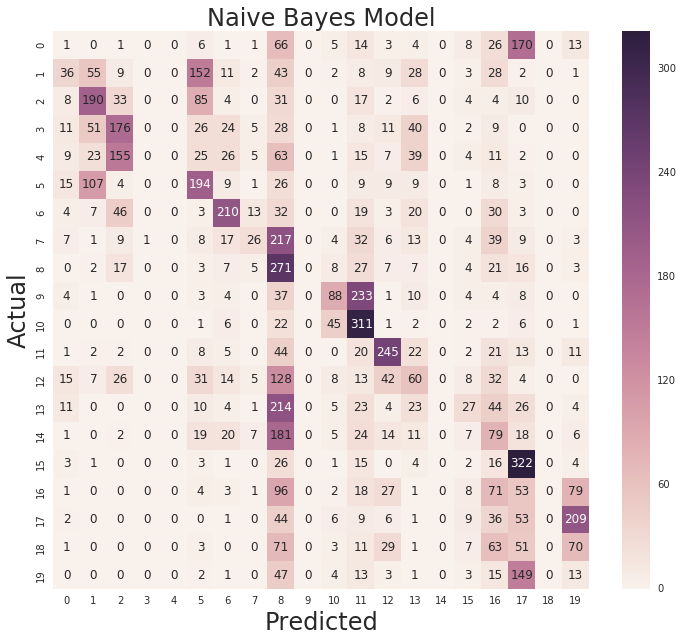

In [9]:
# Create Confusion Plot
fig, ax = plt.subplots(figsize=(12, 10))

from helper_code import mlplots as mp
mp.confusion(test['target'], ts_preds, range(20), 20, 'Naive Bayes Model')

-----
### Student Activity

- Why are classification results so bad?
- Increase topic model terms.
- Change classifier.
- Use normalized values.

-----

## LDA

Introduce LDA. Start with scikit learn. 

-----

In [10]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_topics=num_topics, max_iter=5,
                                learning_method='online', learning_offset=5.,
                                random_state=23).fit(train_data)

In [11]:
lda_topics = tp.get_topics(cv, lda)

Topic  0: window server widget font postscript motif x11r5 xterm fonts xlib
Topic  1: key clipper encryption chip keys algorithm nsa escrow crypto secure
Topic  2: devils alomar detroit traded phillies islanders toronto pittsburgh chicago montreal
Topic  3: msg centris vram simm dram test food hudson venus chinese
Topic  4: subscribe quit navy mailing min mil uu gps newsletter ac
Topic  5: ax satan angels soderstrom hulk max q6 g9v giz bxn
Topic  6: printers radar detector greece detectors uv cyprus greek bj laser
Topic  7: just don like people think know good time does ve
Topic  8: windows thanks drive card file dos use pc files scsi
Topic  9: accelerator muscle ml mm kg dh pl p2 printf dm


-----

### Visualizing Topics

-----

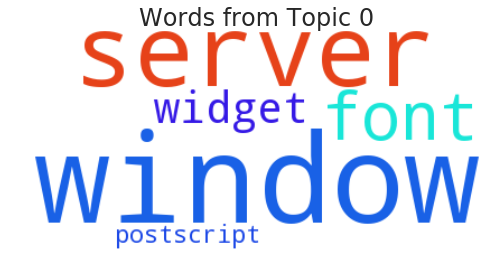

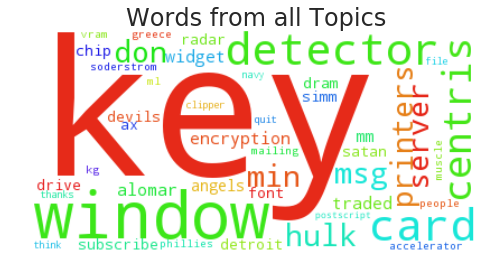

In [12]:
from helper_code import wcviz as wc

wc.make_wc(lda_topics[0].replace(',', ''), 'Words from Topic 0')

text = ', '.join(lda_topics)
wc.make_wc(text.replace(',', ''), 'Words from all Topics')

-----

### Student Activity

In the preceding cells, we . Now
that you have run the Notebook, try making the following changes.

1. ... . Can you ?

2. Change 

3. Using 

4. Try 

-----

## Gensim

Start with simple intro to gensim

-----

In [13]:
# Next section follows gensim tutorial

# As a text example, we use the course description for INFO490  SP16.
info_course = ['Advanced Data Science: This class is an asynchronous, online course.', 
               'This course will introduce advanced data science concepts by building on the foundational concepts presented in INFO 490: Foundations of Data Science.', 
               'Students will first learn how to perform more statistical data exploration and constructing and evaluating statistical models.', 
               'Next, students will learn machine learning techniques including supervised and unsupervised learning, dimensional reduction, and cluster finding.', 
               'An emphasis will be placed on the practical application of these techniques to high-dimensional numerical data, time series data, image data, and text data.', 
               'Finally, students will learn to use relational databases and cloud computing software components such as Hadoop, Spark, and NoSQL data stores.', 
               'Students must have access to a fairly modern computer, ideally that supports hardware virtualization, on which they can install software.', 
               'This class is open to sophomores, juniors, seniors and graduate students in any discipline who have either taken a previous INFO 490 data science course or have received instructor permission.']

# Simple stop words
stop_words = set('for a of the and to in on an'.split())

# Parse text into words, make lowercase and remove stop words
txts = [[word for word in sentance.lower().split() if word not in stop_words]
        for sentance in info_course]

# Keep only those words appearing more than once
# Easy with a Counter, but need a flat list
from collections import Counter
frequency = Counter([word for txt in txts for word in txt])

# Now grab tokens that appear more than once
tokens = [[token for token in txt if frequency[token] > 1]
          for txt in txts]

# Display the tokens
import pprint
pp = pprint.PrettyPrinter(indent=2, depth=2, width=80, compact=True)

pp.pprint(tokens)

[ ['advanced', 'data', 'this', 'class', 'is'],
  [ 'this', 'course', 'will', 'advanced', 'data', 'science', 'concepts',
    'concepts', 'info', 'data'],
  ['students', 'will', 'learn', 'statistical', 'data', 'statistical'],
  ['students', 'will', 'learn', 'techniques'],
  ['will', 'techniques', 'data,', 'data,', 'data,'],
  ['students', 'will', 'learn', 'data'], ['students', 'have'],
  [ 'this', 'class', 'is', 'students', 'have', 'info', 'data', 'science',
    'course', 'have']]


In [14]:
from gensim import corpora
dict_gensim = corpora.Dictionary(tokens)
print(dict_gensim)

Dictionary(16 unique tokens: ['techniques', 'learn', 'science', 'course', 'data,']...)


In [15]:
print(dict_gensim.token2id)

{'techniques': 13, 'learn': 11, 'science': 8, 'course': 6, 'data,': 14, 'will': 7, 'students': 10, 'concepts': 5, 'class': 0, 'is': 4, 'have': 15, 'advanced': 1, 'this': 2, 'data': 3, 'info': 9, 'statistical': 12}


In [16]:
new_txt = 'data science is cool, you should take this course to learn data concepts'
new_vec = dict_gensim.doc2bow(new_txt.lower().split())
pp.pprint(new_vec)

[(2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (8, 1), (11, 1)]


In [17]:
crps = [dict_gensim.doc2bow(txt) for txt in txts]
print(crps)

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)], [(1, 1), (2, 1), (3, 2), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1)], [(3, 1), (7, 1), (10, 1), (11, 1), (12, 2)], [(7, 1), (10, 1), (11, 1), (13, 1)], [(7, 1), (13, 1), (14, 3)], [(3, 1), (7, 1), (10, 1), (11, 1)], [(10, 1), (15, 1)], [(0, 1), (2, 1), (3, 1), (4, 1), (6, 1), (8, 1), (9, 1), (10, 1), (15, 2)]]


In [18]:
from gensim import models

tfidf = models.TfidfModel(crps)

In [19]:
print(new_txt)
print(new_vec)

pp.pprint(tfidf[new_vec])

data science is cool, you should take this course to learn data concepts
[(2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (8, 1), (11, 1)]
[ (2, 0.2731153103729994), (3, 0.2617482842884797), (4, 0.3860184772660643),
  (5, 0.5790277158990964), (6, 0.3860184772660643), (8, 0.3860184772660643),
  (11, 0.2731153103729994)]


In [20]:
crps_tfidf = tfidf[crps]
lda_gs = models.LdaModel(corpus=crps_tfidf, id2word=dict_gensim, num_topics=3, passes=5)

In [21]:
lda_gs.print_topics(3)

['0.194*data, + 0.081*techniques + 0.060*will + 0.054*have + 0.052*students + 0.051*learn + 0.051*data + 0.051*statistical + 0.051*class + 0.051*is',
 '0.093*is + 0.093*class + 0.091*concepts + 0.091*advanced + 0.089*this + 0.082*have + 0.072*science + 0.072*course + 0.072*info + 0.064*data',
 '0.156*learn + 0.116*students + 0.107*statistical + 0.103*have + 0.092*techniques + 0.091*will + 0.068*data + 0.030*class + 0.030*info + 0.030*course']

In [22]:
import operator

for idx, txt in enumerate(lda_gs[crps_tfidf]):
    srt_txt = sorted(txt, key=operator.itemgetter(1))
    print('Sentance {0:1d} has primary topic {1:1d} with probability = {2:4.3f}'\
          .format(idx, srt_txt[-1][0], srt_txt[-1][1]))

Sentance 0 has primary topic 1 with probability = 0.782
Sentance 1 has primary topic 1 with probability = 0.789
Sentance 2 has primary topic 2 with probability = 0.729
Sentance 3 has primary topic 2 with probability = 0.757
Sentance 4 has primary topic 0 with probability = 0.686
Sentance 5 has primary topic 2 with probability = 0.761
Sentance 6 has primary topic 2 with probability = 0.686
Sentance 7 has primary topic 1 with probability = 0.801


In [23]:
ttps = lda_gs.top_topics(corpus=crps_tfidf, num_words=5)
idx = 0

for lst, val in ttps:
    print('Topic {0}'.format(idx))
    print(35*('-'))
    idx += 1
    for i, z in lst:
        print('    {0:20s}: {1:5.4f}'.format(z, i))
    print(35*('-'))

Topic 0
-----------------------------------
    is                  : 0.0933
    class               : 0.0930
    concepts            : 0.0913
    advanced            : 0.0906
    this                : 0.0890
-----------------------------------
Topic 1
-----------------------------------
    data,               : 0.1939
    techniques          : 0.0808
    will                : 0.0604
    have                : 0.0535
    students            : 0.0522
-----------------------------------
Topic 2
-----------------------------------
    learn               : 0.1557
    students            : 0.1158
    statistical         : 0.1074
    have                : 0.1031
    techniques          : 0.0924
-----------------------------------


-----

### Topic Modelling with gensim

Apply gensim to the problem we have been analyzing.

-----

In [24]:
from gensim import matutils as mat
from gensim import models as md
from gensim.corpora.dictionary import Dictionary

# transform sparse matrix into gensim corpus
td_gensim = mat.Sparse2Corpus(train_data, documents_columns=False)

# Build temporary dictionary from scikit learn vectorizer
# for use with gensim
tmp_dct = dict((id, word) for word, id in cv.vocabulary_.items())
dct = Dictionary.from_corpus(td_gensim, id2word=tmp_dct)

In [25]:
# LSI

lsi = md.lsimodel.LsiModel(corpus=td_gensim, id2word=dct, num_topics=5)
lsi.print_topics()

['0.167*"don" + 0.164*"just" + 0.162*"like" + 0.161*"know" + 0.153*"people" + 0.138*"think" + 0.128*"does" + 0.115*"good" + 0.114*"use" + 0.110*"time"',
 '-0.255*"god" + 0.240*"windows" + 0.228*"thanks" + -0.190*"people" + 0.159*"card" + 0.146*"drive" + 0.124*"dos" + -0.116*"jesus" + 0.115*"file" + 0.114*"mail"',
 '-0.486*"god" + -0.186*"jesus" + -0.157*"windows" + -0.148*"does" + -0.131*"thanks" + 0.126*"year" + -0.120*"bible" + 0.118*"pitt" + 0.117*"geb" + 0.116*"dsl"',
 '-0.266*"edu" + -0.237*"geb" + -0.235*"dsl" + -0.235*"chastity" + -0.235*"n3jxp" + -0.235*"cadre" + -0.234*"shameful" + -0.234*"pitt" + -0.233*"skepticism" + -0.233*"intellect"',
 '0.312*"key" + -0.238*"drive" + -0.221*"god" + 0.182*"chip" + 0.176*"government" + 0.170*"encryption" + 0.154*"clipper" + -0.148*"game" + 0.136*"use" + 0.133*"keys"']

In [26]:
# LDA

lda_gs = md.LdaModel(corpus=td_gensim, id2word=dct, num_topics=5, passes=2)
lda_gs.show_topics()

['0.006*god + 0.006*people + 0.004*don + 0.004*think + 0.004*say + 0.003*just + 0.003*know + 0.003*believe + 0.003*does + 0.003*jesus',
 '0.004*key + 0.004*game + 0.004*team + 0.003*year + 0.003*just + 0.003*like + 0.003*don + 0.003*think + 0.003*know + 0.002*time',
 '0.008*windows + 0.006*thanks + 0.006*file + 0.006*use + 0.006*know + 0.005*program + 0.005*files + 0.005*does + 0.005*window + 0.004*using',
 '0.007*drive + 0.005*card + 0.004*new + 0.004*scsi + 0.004*thanks + 0.004*price + 0.004*00 + 0.004*edu + 0.004*sale + 0.004*mail',
 '0.006*car + 0.004*just + 0.004*don + 0.004*bike + 0.004*like + 0.004*people + 0.004*right + 0.003*good + 0.003*gun + 0.003*think']

In [27]:
ttps = lda_gs.top_topics(corpus=td_gensim, num_words=5)

In [28]:
idx = 0

for lst, val in ttps:
    print('Topic {0}'.format(idx))
    print(35*('-'))
    idx += 1
    for i, z in lst:
        print('    {0:20s}: {1:5.4f}'.format(z, i))
    print(35*('-'))

Topic 0
-----------------------------------
    god                 : 0.0062
    people              : 0.0055
    don                 : 0.0041
    think               : 0.0040
    say                 : 0.0037
-----------------------------------
Topic 1
-----------------------------------
    windows             : 0.0077
    thanks              : 0.0065
    file                : 0.0060
    use                 : 0.0058
    know                : 0.0057
-----------------------------------
Topic 2
-----------------------------------
    car                 : 0.0056
    just                : 0.0044
    don                 : 0.0040
    bike                : 0.0039
    like                : 0.0039
-----------------------------------
Topic 3
-----------------------------------
    key                 : 0.0041
    game                : 0.0039
    team                : 0.0037
    year                : 0.0035
    just                : 0.0032
-----------------------------------
Topic 4
------------

-----

### Student Activity

In the preceding cells, we . Now
that you have run the Notebook, try making the following changes.

1. ... . Can you ?

2. Change 

3. Using 

4. Try 

-----